#### Импортируем библиотеки

In [2650]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

#### Функции

In [2652]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Функция для оценки качества модели, принимает предсказанные значения и сравнивает их с реальными.
    Работает для учебной и тестовой выборки.
    
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [2653]:
def predict_and_fill_null(source, value_with_null):
    """
    Функция для заполнения пропущенных значений в таблице на основе метода GradientBoostingRegressor.
    Использует все числовые поля без пропущенных значений.
    
    source - таблица, в которой нужно заполнить данные
    value_with_null - поле с пропущенными значениями
    
    """
    null_columns = source.columns[source.isna().any()]
    
    target_for_pred = source[source[value_with_null].isnull()]
    target_for_pred = target_for_pred.select_dtypes(include=['float64', 'int64']).drop(columns=null_columns)
    
    target_notnull = source[source[value_with_null].notnull()]

    data = target_notnull.select_dtypes(include=['float64', 'int64']).drop(columns=null_columns).columns
    
    X_train = pd.DataFrame(target_notnull, columns = data)
    y_train = pd.DataFrame(target_notnull, columns=[value_with_null])

    gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=42)
    gb_model.fit(X_train, y_train)
    
    target_pred = gb_model.predict(target_for_pred)
    
    source.loc[source[value_with_null].isnull(), value_with_null] = target_pred

#### Директории

In [2654]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

#### **Данные**

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [2655]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Проверим, что тестовые данные содержат тот же набор полей, за исключением целевой переменной

In [2656]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [2657]:
train_df.shape[1] == test_df.shape[1]+1

True

Посмотрим, какие типы данных используются

In [2658]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [2659]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

У нас есть 3 категориальные переменные, позже рассмотрим их отдельно

Чтобы случайно не передать id в модель, заменим тип данных на строковый

In [2660]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [2661]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

Теперь проверим датасеты на пропущенные значения

In [2662]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [2663]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Мы видим, что есть пропущенные значения в данных о жилой площади, а также в некоторых данных, связанных с охраной здоровья. Также нужно будет отдельно проверить категориальные переменные

### Анализ целевой переменной

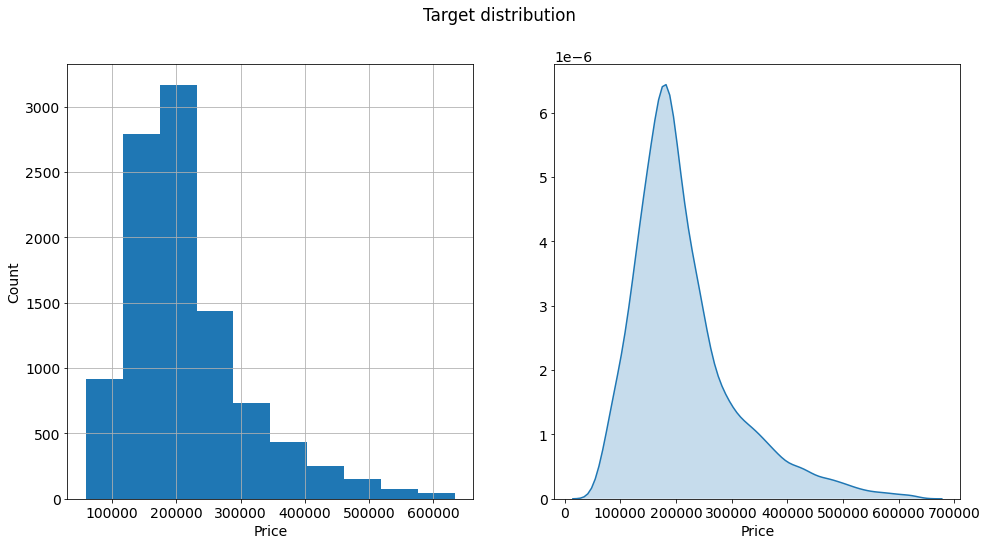

In [2664]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist()
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Target distribution')
plt.show()

График выглядит нормально, выбросов не видно

In [2665]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.86, 192269.64487934904, 59174.77802758122)

#### Количественные переменные

In [2666]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Категориальные переменные

In [2667]:
train_df.select_dtypes(include='object').head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B


In [2668]:
object_columns = train_df.select_dtypes(include='object').columns.tolist()

for column in object_columns[2:]:
    print(str(column) + '\n\n' + str(train_df[column].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



Мы видим, что в категориальных переменных нет прочерков или пропущенных значений. В каждой переменной есть 2 значения, при этом значение "B" сильно преобладает. В дальнейшем, преобразуем их в бинарные

### **Обработка выбросов**

In [2669]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**rooms**

In [2670]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [2671]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [2672]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
test_df.loc[test_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = test_df['Rooms'].median()

**squares**

Удалим выбросы по процентилям

In [2673]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [2674]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809487,34.830304,6.075329,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1156.072932,1.392636,4.438577,214939.479049
std,0.797003,16.225349,14.280535,3.503611,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.814421,1.492092,4.837340,89654.209673
min,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.637555,22.863805,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.440088
50%,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503
75%,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.580780
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [2675]:
train_df.loc[train_df['LifeSquare'] < 12, 'LifeSquare'] = 12
test_df.loc[test_df['LifeSquare'] < 12, 'LifeSquare'] = 12

In [2676]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [2677]:
train_df.loc[train_df["Square"] < train_df["LifeSquare"], ["Square"]] = train_df["LifeSquare"]
test_df.loc[test_df["Square"] < test_df["LifeSquare"], ["Square"]] = test_df["LifeSquare"]

**floors**

In [2678]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [2679]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42])

In [2680]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [2681]:
check = train_df[train_df["Floor"] > train_df["HouseFloor"]]
check.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14,10953,27,1.0,53.769097,52.408027,3.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2.0,64.711835,NaN,3.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
35,6486,200,3.0,85.280389,58.447967,9.0,6,5.0,1960,0.000000,B,B,33,7425,1,NaN,2,5,B,402871.916317
51,10103,94,1.0,35.280894,23.354176,6.0,11,9.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B,148862.210174


In [2682]:
train_df.loc[train_df["HouseFloor"] < train_df["Floor"], ["HouseFloor"]] = train_df["Floor"]
test_df.loc[test_df["HouseFloor"] < test_df["Floor"], ["HouseFloor"]] = test_df["Floor"]

**house year**

In [2683]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
2493        2020
9674        2020
4376        2020
          ...   
8144        1917
1380        1917
5053        1917
7611        1916
910         1914
Name: HouseYear, Length: 8881, dtype: int64

In [2684]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
2493        2020
9674        2020
4376        2020
          ...   
8144        1917
1380        1917
5053        1917
7611        1916
910         1914
Name: HouseYear, Length: 8881, dtype: int64

In [2685]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Обработка пропусков

In [2686]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [2687]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

**LifeSquare**

In [2688]:
predict_and_fill_null(train_df, 'LifeSquare')

train_df.loc[train_df["LifeSquare"] > train_df["Square"], ["LifeSquare"]] = train_df["Square"]

In [2689]:
predict_and_fill_null(test_df, 'LifeSquare')

test_df.loc[test_df["LifeSquare"] > test_df["Square"], ["LifeSquare"]] = test_df["Square"]

**Healthcare_1**

In [2690]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [2691]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

#### Построение новых признаков

**dummies**

In [2692]:
train_df["Ecology_2"].value_counts()

B    8792
A      89
Name: Ecology_2, dtype: int64

In [2693]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [2694]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize**

In [2695]:
train_district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

train_district_size.head(10)

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279
5,30,209
6,53,166
7,21,162
8,62,150
9,58,146


In [2696]:
train_df = train_df.merge(train_district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,990.0,0,11,B,184966.930730,1,1,1,20
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,146
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,95
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,4,990.0,0,6,B,215898.447742,1,1,1,54


In [2697]:
test_district_size = test_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

test_df = test_df.merge(test_district_size, on='DistrictId', how='left')

**IsDistrictLarge**

In [2698]:
train_df['DistrictSize'].median()

90.0

In [2699]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [2700]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,990.0,0,11,B,184966.930730,1,1,1,20,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,1,1,1,86,0
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,1,1,1,146,1
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,1,1,1,95,0
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,990.0,0,6,B,215898.447742,1,1,1,54,0


In [2701]:
test_df.std()

Rooms                 0.837725
Square               19.378469
LifeSquare           17.415328
KitchenSquare         9.640921
Floor                 5.483228
HouseFloor            6.231945
HouseYear            18.573149
Ecology_1             0.120070
Social_1             17.532202
Social_2           4026.614773
Social_3             23.863762
Healthcare_1        766.595258
Helthcare_2           1.479940
Shops_1               4.777365
Ecology_2_bin         0.097518
Ecology_3_bin         0.170052
Shops_2_bin           0.275001
DistrictSize        127.381882
IsDistrictLarge       0.468422
dtype: float64

**MedPriceByDistrict**

In [2702]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146154.352249
4,1,2.0,202944.331497


In [2703]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,20,0,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,300009.450063
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,146,1,169246.115943
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,95,0,158791.017955
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,0,6,B,215898.447742,1,1,1,54,0,384517.540046


In [2704]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [2705]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

In [2706]:
test_df.std()

Rooms                     0.837725
Square                   19.378469
LifeSquare               17.415328
KitchenSquare             9.640921
Floor                     5.483228
HouseFloor                6.231945
HouseYear                18.573149
Ecology_1                 0.120070
Social_1                 17.532202
Social_2               4026.614773
Social_3                 23.863762
Healthcare_1            766.595258
Helthcare_2               1.479940
Shops_1                   4.777365
Ecology_2_bin             0.097518
Ecology_3_bin             0.170052
Shops_2_bin               0.275001
DistrictSize            127.381882
IsDistrictLarge           0.468422
MedPriceByDistrict    69108.487511
dtype: float64

**FloorRel**

In [2707]:
train_df['FloorRel'] = (train_df['Floor'] / train_df['HouseFloor'])

In [2708]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,FloorRel
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,1,1,1,20,0,203384.328026,0.777778
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,1,1,1,86,0,300009.450063,0.777778
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,1,1,1,146,1,169246.115943,0.470588
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,1,1,1,95,0,158791.017955,0.916667
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,6,B,215898.447742,1,1,1,54,0,384517.540046,0.294118


In [2709]:
test_df['FloorRel'] = (test_df['Floor'] / test_df['HouseFloor'])

**SocialAndHealth**

In [2710]:
train_df['SocialAndHealth'] = (train_df['Social_1'] + train_df['Social_2'] + train_df['Social_3']\
                               + train_df['Healthcare_1'] + train_df['Helthcare_2'])

In [2711]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,FloorRel,SocialAndHealth
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,184966.930730,1,1,1,20,0,203384.328026,0.777778,9004.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,300009.450063,1,1,1,86,0,300009.450063,0.777778,10597.0
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,175616.227217,1,1,1,146,1,169246.115943,0.470588,6845.0
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,150226.531644,1,1,1,95,0,158791.017955,0.916667,7892.0
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,B,215898.447742,1,1,1,54,0,384517.540046,0.294118,8744.0


In [2712]:
test_df['SocialAndHealth'] = (test_df['Social_1'] + test_df['Social_2'] + test_df['Social_3']\
                               + test_df['Healthcare_1'] + test_df['Helthcare_2'])

In [2713]:
test_df.std()

Rooms                     0.837725
Square                   19.378469
LifeSquare               17.415328
KitchenSquare             9.640921
Floor                     5.483228
HouseFloor                6.231945
HouseYear                18.573149
Ecology_1                 0.120070
Social_1                 17.532202
Social_2               4026.614773
Social_3                 23.863762
Healthcare_1            766.595258
Helthcare_2               1.479940
Shops_1                   4.777365
Ecology_2_bin             0.097518
Ecology_3_bin             0.170052
Shops_2_bin               0.275001
DistrictSize            127.381882
IsDistrictLarge           0.468422
MedPriceByDistrict    69108.487511
FloorRel                  0.287265
SocialAndHealth        4139.700614
dtype: float64

#### Отбор признаков

In [2714]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'IsDistrictLarge',\
                 'MedPriceByDistrict', 'FloorRel', 'SocialAndHealth']

target_name = 'Price'

In [2715]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names]

In [2716]:
train_df.shape[1] - 1 == test_df.shape[1]

True

#### Стандартизация признаков

In [2717]:
feature_names_for_stand = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'IsDistrictLarge',\
                 'FloorRel', 'SocialAndHealth']
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2_bin',
 'IsDistrictLarge',
 'FloorRel',
 'SocialAndHealth']

In [2718]:
scaler = StandardScaler()
train_df_stand = scaler.fit_transform(train_df[feature_names_for_stand])
test_df_stand = scaler.transform(test_df[feature_names_for_stand])

In [2719]:
train_df[feature_names_for_stand] = pd.DataFrame(train_df_stand, columns=feature_names_for_stand)
test_df[feature_names_for_stand] = pd.DataFrame(test_df_stand, columns=feature_names_for_stand)

In [2720]:
train_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,MedPriceByDistrict,FloorRel,SocialAndHealth,Price
0,0.144819,-0.424784,-0.531218,-0.210964,-0.281814,-0.752810,-0.847599,-0.255590,0.100612,0.176057,...,-0.140109,-0.117517,-0.933397,1.356488,0.275614,-0.893589,203384.328026,0.426214,0.552138,184966.930730
1,1.399590,0.666512,0.178733,0.504413,-0.281814,-0.752810,-0.357728,-0.999192,0.100612,0.176057,...,-0.304760,-1.099658,-0.263159,2.390172,0.275614,-0.893589,300009.450063,0.426214,0.941681,300009.450063
2,0.144819,-0.093647,1.027583,0.862102,-0.087014,0.605107,-0.412158,2.660035,0.100612,0.176057,...,-0.222434,0.005578,-0.933397,0.116067,0.275614,1.119083,169246.115943,-0.637594,0.024187,175616.227217
3,-1.109952,-0.938457,-0.910503,0.146725,0.497386,-0.243591,-0.466588,-0.896650,0.100612,0.176057,...,-0.304760,1.307242,0.407078,-0.090670,0.275614,-0.893589,158791.017955,0.907190,0.280215,150226.531644
4,1.399590,1.572788,0.622783,1.935169,-0.671414,0.605107,1.438468,1.586826,0.100612,0.176057,...,-0.181272,-0.117517,-0.933397,0.322804,0.275614,-0.893589,384517.540046,-1.248718,0.488559,215898.447742


In [2721]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,MedPriceByDistrict,FloorRel,SocialAndHealth
0,0.144819,-0.307586,-0.264151,-0.210964,-0.476614,0.095888,-0.684309,1.592844,0.100612,0.176057,...,-0.724664,-0.304760,-0.235374,-0.933397,-0.917617,0.275614,-0.893589,169246.115943,-0.783100,-0.754655
1,0.144819,0.887184,1.041532,-1.284031,-0.476614,-1.262028,-0.412158,-0.366424,0.100612,0.176057,...,-1.054253,-0.222434,-0.235374,-0.933397,-0.504144,0.275614,-0.893589,242298.108379,1.195776,-1.075974
2,-1.109952,-2.399570,-1.434454,1.935169,-1.255813,-1.431768,-4.113409,-0.999777,0.100612,0.176057,...,0.479556,3.235231,4.743427,2.417792,0.116067,0.275614,-0.893589,197419.043625,-0.882044,1.373285
3,0.144819,1.120424,0.974661,0.862102,2.640184,1.453805,1.220747,-0.148335,0.100612,0.176057,...,-0.263340,-0.222434,-0.235374,1.077316,-0.297407,0.275614,-0.893589,222227.584211,1.195776,-0.301777
4,-1.109952,-0.452799,0.402159,-1.284031,1.666185,0.605107,1.765049,-0.396690,0.100612,0.176057,...,-1.257387,-0.304760,-0.235374,-0.933397,-0.917617,-3.628261,1.119083,121091.843464,1.195776,-1.275025


In [2722]:
test_df.std()

Rooms                     1.051153
Square                    1.194642
LifeSquare                1.165671
KitchenSquare             3.448450
Floor                     1.068132
HouseFloor                1.057808
HouseYear                 1.010939
Ecology_1                 1.003534
Ecology_2_bin             0.979056
Ecology_3_bin             0.995832
Social_1                  1.015257
Social_2                  1.012303
Social_3                  0.982297
Healthcare_1              1.003873
Helthcare_2               0.991912
Shops_1                   0.987657
Shops_2_bin               1.073568
IsDistrictLarge           0.942779
MedPriceByDistrict    69108.487511
FloorRel                  0.994810
SocialAndHealth           1.012300
dtype: float64

#### Разбиение на train и valid

In [2723]:
test_df = test_df[feature_names]
X = train_df[feature_names]
y = train_df[target_name]

In [2724]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

#### **Обучение и оценка модели**

In [2725]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

Train R2:	0.875
Test R2:	0.743


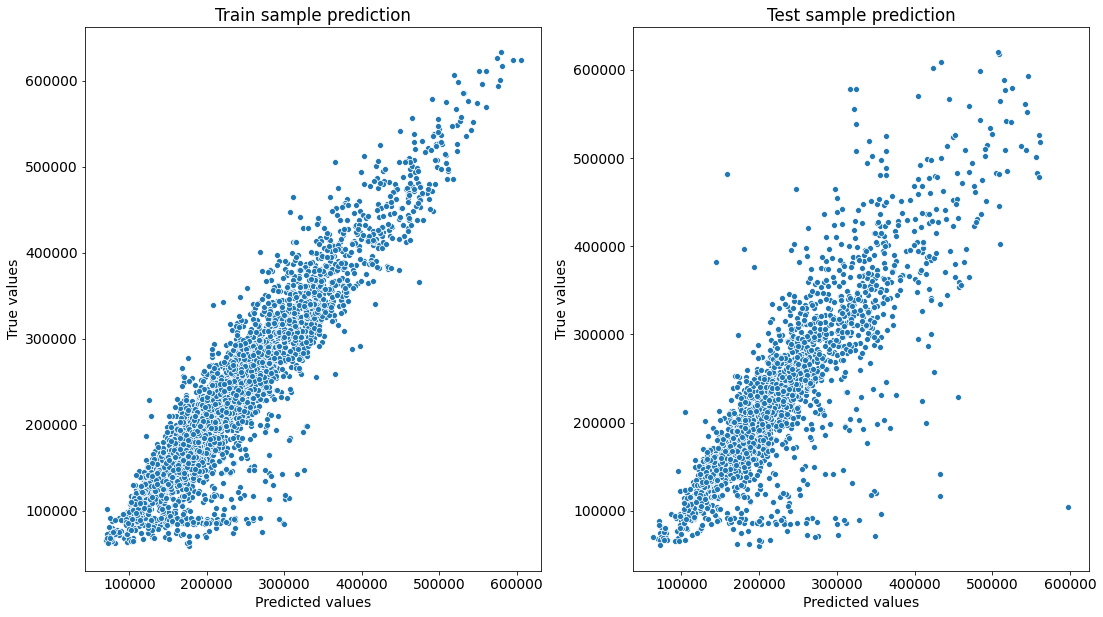

In [2726]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Важность признаков

In [2727]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.701462
1,Square,0.113361
6,HouseYear,0.024109
3,KitchenSquare,0.022841
12,Social_3,0.021591
5,HouseFloor,0.016970
2,LifeSquare,0.013451
4,Floor,0.012508
11,Social_2,0.011986
13,Healthcare_1,0.011687


#### Предсказываем значения для тестовой выборки

In [2728]:
y_test_preds = gb_model.predict(test_df)

In [2729]:
y_test_preds

array([159470.68200527, 242906.0584316 , 261638.84417177, ...,
       340167.40130658, 194705.66861165, 181994.38740324])

In [2730]:
test_df['Price'] = y_test_preds

In [2731]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               5000 non-null   float64
 1   Square              5000 non-null   float64
 2   LifeSquare          5000 non-null   float64
 3   KitchenSquare       5000 non-null   float64
 4   Floor               5000 non-null   float64
 5   HouseFloor          5000 non-null   float64
 6   HouseYear           5000 non-null   float64
 7   Ecology_1           5000 non-null   float64
 8   Ecology_2_bin       5000 non-null   float64
 9   Ecology_3_bin       5000 non-null   float64
 10  Social_1            5000 non-null   float64
 11  Social_2            5000 non-null   float64
 12  Social_3            5000 non-null   float64
 13  Healthcare_1        5000 non-null   float64
 14  Helthcare_2         5000 non-null   float64
 15  Shops_1             5000 non-null   float64
 16  Shops_

In [2732]:
result = test_df['Price'].reset_index()

In [2733]:
result

,index,Price
0,0,159470.682005
1,1,242906.058432
2,2,261638.844172
3,3,293464.058581
4,4,132859.053688
...,...,...
4995,4995,237788.011119
4996,4996,132639.733077
4997,4997,340167.401307
4998,4998,194705.668612


In [2734]:
new_file = 'ARomashkin_preds.csv'
result.to_csv(new_file, index=False, encoding='utf-8')

In [2735]:
check = 'ARomashkin_preds.csv'
check_df = pd.read_csv(check)
check_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB
